In [1]:
import glob
import os
from typing import List, Sequence, Dict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import boa.acquisition.util as util
from boa.optimization.data import FileHandler, Data
from boa.datasets.loader import load_dataset

objective_labels = ['cycle', 'avg_power', 'total_area']
save_folder = "../plots/notebook_plots/bayesopt_analysis/"

In [2]:
def load_runs(directory: str) -> List[Data]:
    data_points = []
    for path in glob.glob(os.path.join(directory, '*.json')):
        handler = FileHandler(path=path)
        data_points.append(handler.load())
    return data_points


def calculate_volumes(dfs: Sequence[pd.DataFrame], min_max: pd.DataFrame) -> List[pd.DataFrame]:
    normed_reference = np.array([1, 1, 1])

    volumes_list = []
    for df in dfs:
        points = df[objective_labels]
        normed_points = (points - min_max['min']) / (min_max['max'] - min_max['min'])
        volumes = [(size, util.calculate_hypervolume(points=normed_points.values[:size], reference=normed_reference))
                   for size in range(10, normed_points.shape[0])]
        volumes_list.append(pd.DataFrame(volumes, columns=['size', 'volume']))

    return volumes_list


def summarize(volumes_list):
    frames = pd.concat([d.set_index('size') for d in volumes_list], axis=1)
    return frames.apply(lambda row: pd.Series({'mean': np.mean(row), 'std': np.std(row)}), axis=1).reset_index()

In [3]:
def plot_bayesopt_experiment(experiment_dict, volumes_dict, summary_dict):
    
    
    label_dict = {
        'random': 'Random',
        'ff-gp': 'FF-GP',
        'gpar': 'GPAR',
        'mf-gpar': 'MF-GPAR',
        'mf-gpar_3': 'MF-GPAR-3',
        'mf-gpar_5': 'MF-GPAR-5',
    }

    color_dict = {
        'random': 'C0',
        'ff-gp': 'C1',
        'gpar': 'C2',
        'mf-gpar': 'C3',
        'mf-gpar_3': 'C4',
        'mf-gpar_5': 'C5',
    }

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))

    for name, volumes_list in volumes_dict.items():
        for volumes in volumes_list:
            ax.plot(
                volumes['size'],
                volumes['volume'],
                color=color_dict[name],
                alpha=0.3,
                linestyle='dashed',
                zorder=-1,
                label='_nolegend_',
            )

    for name, summary in summary_dict.items():
        ax.fill_between(
            x=summary['size'],
            y1=summary['mean'] + 2 * summary['std'],
            y2=summary['mean'] - 2 * summary['std'],
            color=color_dict[name],
            alpha=0.2,
            zorder=-2,
        )

    ordered_names = ['random', 'ff-gp', 'gpar', 'mf-gpar', 'mf-gpar_3', 'mf-gpar_5']

    for name in ordered_names:
        if name not in summary_dict:
            continue

        ax.plot(summary_dict[name]['size'],
                summary_dict[name]['mean'],
                label=label_dict[name],
                linestyle='solid',
                linewidth=3,
                color=color_dict[name],
                zorder=0)

    ax.legend(loc='lower right', prop={'size': 12})

    ax.set_ylabel('Hypervolume', fontsize=12)
    ax.set_xlabel('Evaluations', fontsize=12)

    fig.show()
    fig.savefig(f'{save_folder}/bayesopt_{kind}.pdf')


In [21]:
def calculate_statistics(experiments_log_dir, dataset_path, kind):

    experiment_dict = {}

    # Discover all experiment directories in the folder where we are saving them all
    experiment_directories = [os.path.join(experiments_log_dir, item) 
                               for item in os.listdir(experiments_log_dir) 
                               if os.path.isdir(os.path.join(experiments_log_dir, item))]

    # Load experiment JSON files
    for directory in experiment_directories:
        experiments = load_runs(directory)

        dfs = [pd.DataFrame(data=np.hstack((experiment.input, experiment.output)), 
                            columns=experiment.input_labels + experiment.output_labels)

               for experiment in experiments]

        base_name = os.path.basename(directory)
        experiment_dict[base_name] = dfs

    # Load the dataset
    dataset = load_dataset(path=dataset_path, kind=kind)
    min_max = dataset.df[objective_labels].apply(lambda column: pd.Series({
        'min': column.min(),
        'max': column.max()
    })).transpose()

    # Calculate summary statistics for the dataset
    volumes_dict = {key: calculate_volumes(experiment, min_max) for key, experiment in experiment_dict.items()}
    summary_dict = {key: summarize(volume) for key, volume in volumes_dict.items()}
    
    return experiment_dict, volumes_dict, summary_dict

In [13]:
old_fft_bayesopt_dir = "../../data/bayesopt-old/data/fft/bayesopt/"

In [14]:
fft_bayesopt_dir = "../logs/fft/bayesopt"
fft_dataset_path = "../resources/fft_dataset.csv"

In [24]:
old_fft_summaries = calculate_statistics(experiments_log_dir=old_fft_bayesopt_dir,
                                         dataset_path=fft_dataset_path,
                                         kind="fft")

In [29]:
new_fft_summaries = calculate_statistics(experiments_log_dir=fft_bayesopt_dir,
                                         dataset_path=fft_dataset_path,
                                         kind="fft")

/scratch/gf332/BayesOpt/tf2-boa-venv/lib/python3.6/site-packages/ipykernel_launcher.py:65: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


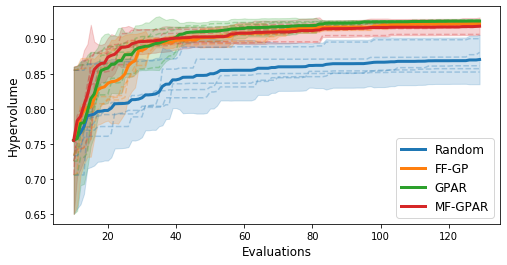

In [26]:
plot_bayesopt_experiment(*old_fft_summaries)

/scratch/gf332/BayesOpt/tf2-boa-venv/lib/python3.6/site-packages/ipykernel_launcher.py:65: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


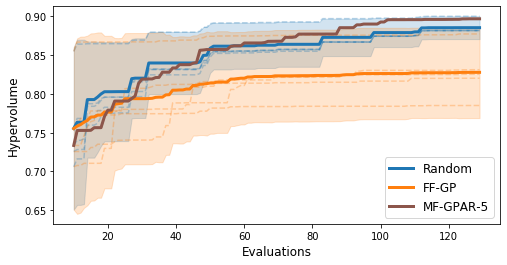

In [30]:
plot_bayesopt_experiment(*new_fft_summaries)